In [ ]:
import sys
print(sys.executable)
import pandas as pd
import numpy as np
import sklearn
print(sklearn.__version__)

C:\Users\patil\anaconda3\envs\newenv\python.exe
1.7.1


In [ ]:
df=pd.read_csv("../Dataset/raw_onion_data.csv")

In [3]:
df = df.iloc[2:]

In [4]:
df.columns = [
    "Day",
    "Date",
    "Gas",
    "Temp_Min",
    "Temp_Max",
    "Hum_Min",
    "Hum_Max",
    "Output",
    "Fan",
    "Heater",
    "C1","C2","C3","C4","C5","C6"
]

In [5]:
df = df[["Day","Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max","Fan"]]

In [6]:
df["Fan"] = df["Fan"].map({"ON":1, "OFF":0})


In [7]:
df = df.dropna()

In [8]:
print(df.head())

  Day  Gas Temp_Min Temp_Max Hum_Min Hum_Max  Fan
2   1  456       26       36      29      65    1
3   2  461       21       32      34      56    1
4   3  487       22       36      50      93    1
5   4  476       20       37      26      98    1
6   5  476       23       39      16      83    1


In [9]:
df.dtypes

Day         object
Gas         object
Temp_Min    object
Temp_Max    object
Hum_Min     object
Hum_Max     object
Fan          int64
dtype: object

In [10]:
cols = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

for col in cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Remove rows that became NaN
df = df.dropna()

print(df.dtypes)


Day         object
Gas          int64
Temp_Min     int64
Temp_Max     int64
Hum_Min      int64
Hum_Max      int64
Fan          int64
dtype: object


In [11]:
df = df.drop("Day", axis=1)

print(df.dtypes)


Gas         int64
Temp_Min    int64
Temp_Max    int64
Hum_Min     int64
Hum_Max     int64
Fan         int64
dtype: object


In [12]:
df = df.drop("Fan", axis=1)


In [13]:
print(df.head())

   Gas  Temp_Min  Temp_Max  Hum_Min  Hum_Max
2  456        26        36       29       65
3  461        21        32       34       56
4  487        22        36       50       93
5  476        20        37       26       98
6  476        23        39       16       83


In [14]:
def assign_speed(temp, hum, gas):

    # Healthy ranges (from your table)
    healthy_gas = (400 <= gas <= 700)
    healthy_temp = (0 <= temp <= 25)
    healthy_hum = (50 <= hum <= 60)

    # Warning ranges
    warning_gas = (700 < gas <= 900)
    warning_temp = (25 < temp < 40)
    warning_hum = (60 < hum < 70)

    # Danger ranges
    danger_gas = (gas > 900)
    danger_temp = (temp >= 40)
    danger_hum = (hum >= 70)

    # Count conditions
    danger_count = sum([danger_gas, danger_temp, danger_hum])
    warning_count = sum([warning_gas, warning_temp, warning_hum])

    # HIGH speed: strong danger
    if danger_count >= 2:
        return 3

    # MEDIUM speed: warning or single danger
    elif danger_count == 1 or warning_count >= 2:
        return 2

    # LOW speed: mostly healthy
    else:
        return 1


In [15]:
df["Speed"] = df.apply(
    lambda r: assign_speed(
        r["Temp_Max"],
        r["Hum_Max"],
        r["Gas"]
    ),
    axis=1
)

print(df["Speed"].value_counts())


Speed
2    167
3     29
1      2
Name: count, dtype: int64


In [16]:
X = df[["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]]
y = df["Speed"]


In [17]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42
)

param_grid = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [6, 8, 10, 12, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    rf,
    param_grid,
    cv=cv,
    scoring="f1_macro",
    n_jobs=-1,
    verbose=2
)

grid.fit(X, y)


Fitting 5 folds for each of 360 candidates, totalling 1800 fits


C:\Users\patil\anaconda3\envs\newenv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [6, 8, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split again for final test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

best_rf = grid.best_estimator_

best_rf.fit(X_train, y_train)

pred = best_rf.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

pred_cv = cross_val_predict(
    best_rf, X, y,
    cv=2
)

print(classification_report(y, pred_cv))


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.94      0.57      0.71       167
           3       0.25      0.62      0.36        29

    accuracy                           0.57       198
   macro avg       0.40      0.40      0.36       198
weighted avg       0.83      0.57      0.65       198



In [21]:
# Merge Low into Medium
df["Speed"] = df["Speed"].replace(1, 2)

print(df["Speed"].value_counts())


Speed
2    169
3     29
Name: count, dtype: int64


In [22]:
X = df[["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]]
y = df["Speed"]


In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=6,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [25]:
from sklearn.metrics import classification_report

pred = rf.predict(X_test)

print(classification_report(y_test, pred))


              precision    recall  f1-score   support

           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00         6

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



In [26]:
df["Speed"] = df["Speed"].replace(1, 2)

print(df["Speed"].value_counts())


Speed
2    169
3     29
Name: count, dtype: int64


In [27]:
from sklearn.model_selection import cross_val_predict

pred_cv = cross_val_predict(
    rf, X, y,
    cv=5
)

print(classification_report(y, pred_cv))


              precision    recall  f1-score   support

           2       0.99      0.85      0.91       169
           3       0.52      0.97      0.67        29

    accuracy                           0.86       198
   macro avg       0.76      0.91      0.79       198
weighted avg       0.92      0.86      0.88       198



In [28]:
import pandas as pd

columns = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

test_cases = [
    [550, 20, 24, 52, 58],
    [780, 28, 33, 60, 65],
    [920, 42, 48, 75, 82],
    [850, 35, 39, 68, 69],
    [980, 50, 55, 85, 90]
]

for case in test_cases:
    df_test = pd.DataFrame([case], columns=columns)
    pred = rf.predict(df_test)
    print(case, "→ Predicted Speed:", pred[0])


[550, 20, 24, 52, 58] → Predicted Speed: 2
[780, 28, 33, 60, 65] → Predicted Speed: 2
[920, 42, 48, 75, 82] → Predicted Speed: 3
[850, 35, 39, 68, 69] → Predicted Speed: 2
[980, 50, 55, 85, 90] → Predicted Speed: 3


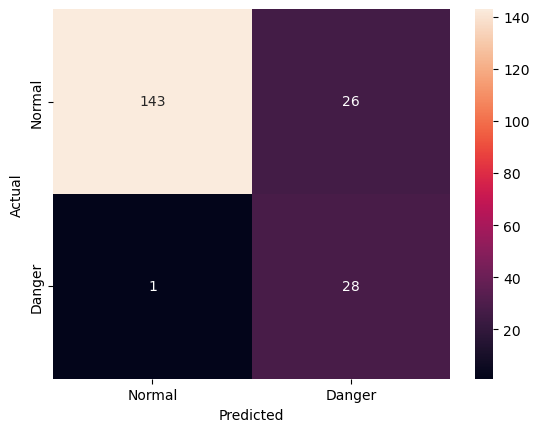

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y, pred_cv)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Normal","Danger"],
            yticklabels=["Normal","Danger"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [30]:
import pandas as pd

columns = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

stress_tests = [
    [1000, 55, 60, 90, 95],
    [950, 45, 50, 75, 80],
    [400, 10, 15, 50, 55],
    [700, 25, 30, 60, 62],
]

for case in stress_tests:
    df_test = pd.DataFrame([case], columns=columns)
    pred = rf.predict(df_test)[0]
    print(case, "→ Predicted Speed:", pred)


[1000, 55, 60, 90, 95] → Predicted Speed: 3
[950, 45, 50, 75, 80] → Predicted Speed: 3
[400, 10, 15, 50, 55] → Predicted Speed: 2
[700, 25, 30, 60, 62] → Predicted Speed: 2


In [31]:
import numpy as np
import pandas as pd

columns = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

sample = np.array([850, 32, 36, 65, 68])

for i in range(10):
    noisy = sample + np.random.normal(0, 2, 5)

    df_test = pd.DataFrame([noisy], columns=columns)

    pred = rf.predict(df_test)[0]

    print("Noisy:", noisy.round(2), "→ Predicted Speed:", pred)


Noisy: [850.55  32.65  38.81  67.08  67.49] → Predicted Speed: 2
Noisy: [854.86  31.35  34.94  65.65  69.24] → Predicted Speed: 2
Noisy: [849.36  34.76  35.48  64.72  66.05] → Predicted Speed: 2
Noisy: [849.72  32.29  37.02  63.6   69.71] → Predicted Speed: 2
Noisy: [848.36  31.26  36.8   61.65  65.6 ] → Predicted Speed: 2
Noisy: [849.39  33.11  34.64  61.79  68.72] → Predicted Speed: 2
Noisy: [848.79  33.82  35.02  65.75  66.61] → Predicted Speed: 2
Noisy: [850.    31.81  31.07  62.84  69.37] → Predicted Speed: 2
Noisy: [848.41  32.95  38.07  66.62  70.88] → Predicted Speed: 2
Noisy: [848.03  30.1   36.47  66.61  69.6 ] → Predicted Speed: 2


In [32]:
import pandas as pd

columns = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

border_cases = [
    [799, 24, 26, 59, 61],
    [801, 26, 28, 61, 63],
    [899, 38, 39, 69, 70],
    [901, 40, 41, 71, 72],
]

for case in border_cases:
    df_test = pd.DataFrame([case], columns=columns)
    pred = rf.predict(df_test)[0]
    print(case, "→ Predicted Speed:", pred)


[799, 24, 26, 59, 61] → Predicted Speed: 2
[801, 26, 28, 61, 63] → Predicted Speed: 2
[899, 38, 39, 69, 70] → Predicted Speed: 2
[901, 40, 41, 71, 72] → Predicted Speed: 3


In [33]:
# Merge class 1 into 2 (if not already done)
df["Speed"] = df["Speed"].replace(1, 2)

# Keep only required columns
final_df = df[[
    "Gas",
    "Temp_Min",
    "Temp_Max",
    "Hum_Min",
    "Hum_Max",
    "Speed"
]]

print(final_df.head())
print(final_df.info())


   Gas  Temp_Min  Temp_Max  Hum_Min  Hum_Max  Speed
2  456        26        36       29       65      2
3  461        21        32       34       56      2
4  487        22        36       50       93      2
5  476        20        37       26       98      2
6  476        23        39       16       83      2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 2 to 199
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Gas       198 non-null    int64
 1   Temp_Min  198 non-null    int64
 2   Temp_Max  198 non-null    int64
 3   Hum_Min   198 non-null    int64
 4   Hum_Max   198 non-null    int64
 5   Speed     198 non-null    int64
dtypes: int64(6)
memory usage: 9.4 KB
None


In [34]:
final_df = final_df.reset_index(drop=True)


In [ ]:
final_df.to_csv(
    "../Dataset/final_onion_ventilation_dataset.csv",
    index=False
)


In [ ]:
import joblib

# Save model
joblib.dump(rf, "../Model/final_fan_speed_model.pkl")

print("Model saved successfully!")


Model saved successfully!


In [ ]:
columns = ["Gas","Temp_Min","Temp_Max","Hum_Min","Hum_Max"]

joblib.dump(columns, "../Model/model_columns.pkl")


['model_columns.pkl']

In [ ]:
#for loading the trained model-

# import joblib

# # Load model
# rf = joblib.load("../Model/final_fan_speed_model.pkl")

# # Load columns
# columns = joblib.load("../Model/model_columns.pkl")

# print("Model loaded successfully!")


#for testing the model

# import pandas as pd

# test = pd.DataFrame(
#     [[920, 42, 48, 75, 82]],
#     columns=columns
# )

# print("Prediction:", rf.predict(test)[0])

